# Forecasting the Stock Market using News Sentiment Analysis

### This project is a reproduction of the findings from the paper "Forecasting the Stock Market using News Sentiment Analysis":

See here: http://arno.uvt.nl/show.cgi?fid=157031

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sn
from sklearn import svm
from textblob import TextBlob
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer, confusion_matrix

### 1.A. News articles preprocessing (all-the-news-2-1.csv):
* keep date, title, section, and publication. 
* all the rows without a title are filtered to assure that each entry has a filled title column
* Some publishers do not have a filled section column; these entries are replaced with “unknown”. However, this study is mainly focused on financial and business news articles and with an “unknown” section column it is impossible to decide whether it belongs to a financial and business article or not. 
* Therefore, this study uses two news article datasets, (1) with all the news articles with a financial or business-related section, and (2) all the news articles with unknown sections combined with dataset 1.

**keep 'date', 'title', 'section', and 'publication' columns**

In [2]:
news_fields = ['date', 'title', 'section', 'publication']
news_df_tmp = pd.read_csv('../data/all-the-news-2-1.csv', usecols=news_fields)
news_df_tmp['date'] = news_df_tmp['date'].astype('datetime64[ns]')
news_df_tmp['date'] = news_df_tmp['date'].dt.date
news_df_tmp = news_df_tmp.sort_values(by='date')

In [3]:
news_df_tmp

,date,title,section,publication
211292,2016-01-01,A Brief Overview of the NBA's Most Notable Hai...,Sports,Vice
606116,2016-01-01,Mark Salling: Glee Star Runs Errand After Post...,crime,People
243526,2016-01-01,Utah Jazz - PlayerWatch,US NBA,Reuters
1407889,2016-01-01,No. 23 Tennessee blasts No. 13 Northwestern,Intel,Reuters
511158,2016-01-01,Here's what to expect at CES 2016 this week | ...,NaN,The Verge
...,...,...,...,...
2683761,2020-04-01,Special teams maven Nate Ebner follows Joe Jud...,NaN,Washington Post
2683603,2020-04-01,Bon Secours to furlough staff not supporting C...,NaN,Washington Post
2683635,2020-04-01,"San Francisco will pay $369,000 to raided repo...",NaN,Washington Post
2688877,2020-04-01,Ruth Bader Ginsburg Still Working Out with Tra...,NaN,TMZ


**We see, that this statemenyt is false. The time period for the news begins at 01.01.2016:**

"The news article dataset contains 2.7 million news articles and essays from 27 American publishers such as the Financial Times, Reuters and Cable News Network (CNN) from 2013 to early 2020."

**all the rows without a title are filtered to assure that each entry has a filled title column**

In [4]:
news_df = news_df_tmp[news_df_tmp['title'].notna()]

In [5]:
news_df

,date,title,section,publication
211292,2016-01-01,A Brief Overview of the NBA's Most Notable Hai...,Sports,Vice
606116,2016-01-01,Mark Salling: Glee Star Runs Errand After Post...,crime,People
243526,2016-01-01,Utah Jazz - PlayerWatch,US NBA,Reuters
1407889,2016-01-01,No. 23 Tennessee blasts No. 13 Northwestern,Intel,Reuters
511158,2016-01-01,Here's what to expect at CES 2016 this week | ...,NaN,The Verge
...,...,...,...,...
2683761,2020-04-01,Special teams maven Nate Ebner follows Joe Jud...,NaN,Washington Post
2683603,2020-04-01,Bon Secours to furlough staff not supporting C...,NaN,Washington Post
2683635,2020-04-01,"San Francisco will pay $369,000 to raided repo...",NaN,Washington Post
2688877,2020-04-01,Ruth Bader Ginsburg Still Working Out with Tra...,NaN,TMZ


**this study uses two news article datasets, (1) with all the news articles with a financial or business-related section...**


**...and (2) all the news articles with unknown sections combined with dataset 1**


**BUT!**

When observing Table 3, the bold depicted scores are the highest of its row. With these results **it can be concluded that dataset 1**, containing only the news articles that have a business or financial related section, **performed better than dataset 2**. Moreover, dataset 1 outperformed dataset 2 on four of the seven different feature sets, and on three occasions, both datasets achieved the same score. Therefore, the following sections will only focus on the performance of the sentiment analysis method and models on dataset

In [6]:
valid_section_values_1 = ['Financials', 'Business News']
news_df_1 = news_df[news_df['section'].isin(valid_section_values_1)]
news_df_1 = news_df_1.reset_index(drop=True)

In [7]:
news_df_1

,date,title,section,publication
0,2016-01-01,Honda confirms ninth death linked to Takata ai...,Business News,Reuters
1,2016-01-01,"China December factory activity shrinks, more ...",Business News,Reuters
2,2016-01-01,China official December services PMI edges up ...,Business News,Reuters
3,2016-01-01,"Apple to pay Italy 318 million euros, sign tax...",Business News,Reuters
4,2016-01-01,India's NSE index ends near 2-month high,Financials,Reuters
...,...,...,...,...
154235,2020-03-28,"S&P cuts DAMAC's rating, puts Emaar Properties...",Financials,Reuters
154236,2020-03-28,Trump considering 'enforceable' quarantine in ...,Business News,CNBC
154237,2020-03-28,"As virus threatens, U.S. embraces big governme...",Business News,Reuters
154238,2020-03-28,"Irish banks processing over 28,000 coronavirus...",Financials,Reuters


### 1.B. News Articles Sentiment Scores
* After preprocessing the news article dataset, some code should be executed to gather the different sentiment score features. As mentioned in Section 3.2 the following sentiment scores are calculated and added to the two news articles datasets: VADER, **TextBlob**, and LM. Hence, each row (news article) has several sentiment score columns. Since the news article and price datasets will be merged on the date columns, a group by date function has been executed. While grouping the rows by the date column, the sentiment scores will be averaged.

In [8]:
def text_blob_sentiment(some_df):
    scores = []
    sentences = list(some_df['title'])
    
    for sent in sentences:
        testimonial = TextBlob(sent)
        scores.append(testimonial.sentiment.polarity)
        
    some_df['TextBlob_Sentiment'] = scores
    return some_df

In [9]:
news_df_1 = text_blob_sentiment(news_df_1)

In [10]:
news_df_1

,date,title,section,publication,TextBlob_Sentiment
0,2016-01-01,Honda confirms ninth death linked to Takata ai...,Business News,Reuters,0.000000
1,2016-01-01,"China December factory activity shrinks, more ...",Business News,Reuters,0.500000
2,2016-01-01,China official December services PMI edges up ...,Business News,Reuters,0.000000
3,2016-01-01,"Apple to pay Italy 318 million euros, sign tax...",Business News,Reuters,0.000000
4,2016-01-01,India's NSE index ends near 2-month high,Financials,Reuters,0.130000
...,...,...,...,...,...
154235,2020-03-28,"S&P cuts DAMAC's rating, puts Emaar Properties...",Financials,Reuters,0.000000
154236,2020-03-28,Trump considering 'enforceable' quarantine in ...,Business News,CNBC,0.136364
154237,2020-03-28,"As virus threatens, U.S. embraces big governme...",Business News,Reuters,0.000000
154238,2020-03-28,"Irish banks processing over 28,000 coronavirus...",Financials,Reuters,0.000000


**drop columns 'title', 'section', 'publication'**

In [11]:
news_df_1.drop(['title', 'section', 'publication'], axis=1, inplace=True)

In [12]:
news_df_1

,date,TextBlob_Sentiment
0,2016-01-01,0.000000
1,2016-01-01,0.500000
2,2016-01-01,0.000000
3,2016-01-01,0.000000
4,2016-01-01,0.130000
...,...,...
154235,2020-03-28,0.000000
154236,2020-03-28,0.136364
154237,2020-03-28,0.000000
154238,2020-03-28,0.000000


**a group by date function has been executed. While grouping the rows by the date column, the sentiment scores will be averaged.**

In [13]:
news_df_1 = news_df_1.groupby('date', as_index=False, sort=True)['TextBlob_Sentiment'].mean()

In [14]:
start = datetime.strptime("01-01-2016", "%d-%m-%Y")
end   = datetime.strptime("31-01-2020", "%d-%m-%Y")

# Convert datetime object to date object.
start = start.date()
end   = end.date()

news_df_1 = news_df_1[(news_df_1['date'] >= start) & (news_df_1['date'] <= end)]

In [15]:
news_df_1

,date,TextBlob_Sentiment
0,2016-01-01,0.114318
1,2016-01-02,0.041667
2,2016-01-03,-0.066667
3,2016-01-04,-0.004649
4,2016-01-05,-0.004303
...,...,...
1487,2020-01-27,0.034606
1488,2020-01-28,0.009579
1489,2020-01-29,0.017997
1490,2020-01-30,0.008438


### 2. S&P 500 preprocessing (YahooFinancials package.xls) (1785 entries before preprocessing, includig keys row)
* keep columns: close price, volume, and date
* Another column has been added with the movement, this is the binary dependent variable in this study. A 1 is assigned if the stock market value went up or remained the same compared to the day before and 0 if the stock market values went down.
* Since it has been decided to use fundamental as well as technical analysis, a column has been added with a technical indicator. Although there are many technical indicators which can be calculated with the features in the S&P 500 dataset, the most common one has been chosen, which is the simple moving average (SMA). To calculate the SMA, all the closing prices are summed up over a given period and divided by the number of periods
SMA = (A1 + A2 + ... + An) / n
* Since the prediction of a stock for the following day is considered as a short-term prediction, the period should is set on 10 days

**keep columns: close price, volume, and date**

In [16]:
fields = ['Date', 'Close*', 'Volume']

sandp_df = pd.read_excel('../data/YahooFinancials package.xls', usecols=fields)
sandp_df.rename(columns = {'Date':'date'}, inplace = True)
sandp_df['date'] = sandp_df['date'].astype('datetime64[ns]')
sandp_df['date'] = sandp_df['date'].dt.date

In [17]:
sandp_df

,date,Close*,Volume
0,2020-01-31,3225.52,4527830000
1,2020-01-30,3283.66,3787250000
2,2020-01-29,3273.40,3584500000
3,2020-01-28,3276.24,3526720000
4,2020-01-27,3243.63,3823100000
...,...,...,...
1779,2013-01-07,1461.89,3304970000
1780,2013-01-04,1466.47,3424290000
1781,2013-01-03,1459.37,3829730000
1782,2013-01-02,1462.42,4202600000


**Another column has been added with the movement, this is the binary dependent variable in this study. A 1 is assigned if the stock market value went up or remained the same compared to the day before and 0 if the stock market values went down.**

In [18]:
def calculate_movement(some_df):
    
    close_list = list(some_df['Close*'])
    
    movement = []  
    for i in range(len(close_list)-1):
        if close_list[i] < close_list[i+1]:
            movement.append(0)
        else:
            movement.append(1)
    movement.append(1)   # there is nothing to compare for the first day, set to 1 (remained the same)
    some_df['movement'] = movement
    return some_df

In [19]:
sandp_df = calculate_movement(sandp_df)

In [20]:
sandp_df.head(15)

,date,Close*,Volume,movement
0,2020-01-31,3225.52,4527830000,0
1,2020-01-30,3283.66,3787250000,1
2,2020-01-29,3273.40,3584500000,0
3,2020-01-28,3276.24,3526720000,1
4,2020-01-27,3243.63,3823100000,0
5,2020-01-24,3295.47,3707130000,0
6,2020-01-23,3325.54,3764860000,1
7,2020-01-22,3321.75,3619850000,1
8,2020-01-21,3320.79,4105340000,0
9,2020-01-17,3329.62,3698170000,1


**To calculate the SMA, all the closing prices are summed up over a given period and divided by the number of periods SMA = (A1 + A2 + ... + An) / n.**

**Since the prediction of a stock for the following day is considered as a short-term prediction, the period should is set on 10 days**

In [21]:
def calculate_SMA(some_df):
    
    close_list = list(some_df['Close*'])
   
    sma = []
    for i in range(len(close_list)-1):
        previous = close_list[i+1:i+11]
        sma.append( (sum(previous))/len(previous) )

    sma.append(close_list[-1])  # there is nothing to compare for the first day, set to current day value  
    some_df['SMA'] = sma
    return some_df

In [22]:
sandp_df = calculate_SMA(sandp_df)

In [23]:
sandp_df.head(3)

,date,Close*,Volume,movement,SMA
0,2020-01-31,3225.52,4527830000,0,3298.691
1,2020-01-30,3283.66,3787250000,1,3299.254
2,2020-01-29,3273.40,3584500000,0,3300.229


In [24]:
sandp_df = sandp_df[(sandp_df['date'] >= start) & (sandp_df['date'] <= end)]
sandp_df = sandp_df.sort_values(by='date')
sandp_df = sandp_df.reset_index(drop=True)

In [25]:
sandp_df

,date,Close*,Volume,movement,SMA
0,2016-01-04,2012.66,4304880000,0,2047.500
1,2016-01-05,2016.71,3706620000,1,2044.577
2,2016-01-06,1990.26,4336660000,0,2045.693
3,2016-01-07,1943.09,5076590000,0,2042.604
4,2016-01-08,1922.03,4664940000,0,2033.016
...,...,...,...,...,...
1022,2020-01-27,3243.63,3823100000,0,3303.590
1023,2020-01-28,3276.24,3526720000,1,3301.418
1024,2020-01-29,3273.40,3584500000,0,3300.229
1025,2020-01-30,3283.66,3787250000,1,3299.254


### 3. Merge Datasets:
* After the datasets are preprocessed, the price dataset has been left joined to the news article datasets to create two datasets that will be used as input and output for the machine and deep learning models. 
* The datasets are merged on the column date. Thus, the two dataset which will be used for this research are fully preprocessed and both contains 1,096 rows. Because both datasets consist of the same features only one table has been created to give an overview of all the features in the datasets.
* The dependent variables have 589 entries that the stock market movement directionality went down, and 480 entries where the stock market price went up or remained the same.
* One small adjustment has been made to the final datasets, which is known as standardization. This method may help to minimize dataset dissimilarities. Rescaling the features to give them the characteristics of a regular normal distribution is known as standardization (or Z-score normalization) (formula on page 20)

In [26]:
merge_1 = news_df_1.merge(sandp_df, how='left', on='date')
merge_1 = merge_1[merge_1['Close*'].notna()]
merge_1['movement'] = merge_1['movement'].astype('int')
merge_1 = merge_1.sort_values(by='date')
merge_1 = merge_1.reset_index(drop=True)

In [27]:
merge_1

,date,TextBlob_Sentiment,Close*,Volume,movement,SMA
0,2016-01-04,-0.004649,2012.66,4.304880e+09,0,2047.500
1,2016-01-05,-0.004303,2016.71,3.706620e+09,1,2044.577
2,2016-01-06,0.037939,1990.26,4.336660e+09,0,2045.693
3,2016-01-07,-0.005610,1943.09,5.076590e+09,0,2042.604
4,2016-01-08,-0.092329,1922.03,4.664940e+09,0,2033.016
...,...,...,...,...,...,...
1022,2020-01-27,0.034606,3243.63,3.823100e+09,0,3303.590
1023,2020-01-28,0.009579,3276.24,3.526720e+09,1,3301.418
1024,2020-01-29,0.017997,3273.40,3.584500e+09,0,3300.229
1025,2020-01-30,0.008438,3283.66,3.787250e+09,1,3299.254


**The author says on page 20: "The dependent variables have 589 entries that the stock market movement directionality went down, and 480 entries where the stock market price went up or remained the same."**

So, he would have 589 + 480 = 1069 entries

**On page 19 the author talks about 1096 entries. There is some inconsistency or this is a typo.**

This number of samples could not be reproduced. The data pre-processing and merging of the two datasets provides **only 1027 samples (569 up or same and 458 down)**, which have filled walues in all features. Maybe, the author forgot to throw out saturdays and sundays in the news dataset. News are printed everyday, while the stock market is open only MO-FR. So, there is no data for the S&P500 parameters for weekends.

My approach now has a weakness. News from saturdays and sundays are not considered. If the author uses the sentiment from news from weekends, he missed to describe how he is handling the missing open, close, volume etc. data for these days. One approach could be to fill these values for each saturday and sunday with the same data, as from the previous friday.

I will not follow this approach at this point. So, the last 10 days for sentiment and technical data for a Monday will be MO-FR from the two previous weeks.



In [28]:
merge_1['movement'].value_counts()

1    569
0    458
Name: movement, dtype: int64

**accortding to the table 1 on page 20, date should be of type "date", movement should be of type "int" and the rest should be of type "float64"**

In [29]:
merge_1.dtypes

date                   object
TextBlob_Sentiment    float64
Close*                float64
Volume                float64
movement                int32
SMA                   float64
dtype: object

## My understanding of the task:
* movement is the target value for the binary classification
* Technical Analysis (TA) represents the volume, close price and the SMA (from paper).
* SVM + TextBlob will use columns: 'TextBlob_Sentiment', 'movement'
* SVM + TextBlob + TA will use columns: 'TextBlob_Sentiment', 'Close*', 'Volume', SMA, 'movement'

In [30]:
svm_textblob = merge_1[['TextBlob_Sentiment']]
svm_textblob_ta = merge_1[['TextBlob_Sentiment', 'Close*', 'Volume', 'SMA']]
y = list(merge_1['movement'])

**One small adjustment has been made to the final datasets, which is known as standardization. This method may help to minimize dataset dissimilarities. Rescaling the features to give them the characteristics of a regular normal distribution is known as standardization (or Z-score normalization)**

In [31]:
svm_textblob = svm_textblob.apply(zscore)
svm_textblob_ta = svm_textblob_ta.apply(zscore)

In [32]:
svm_textblob.head(3)

,TextBlob_Sentiment
0,-1.481421
1,-1.463648
2,0.706539


In [33]:
svm_textblob_ta.head(3)

,TextBlob_Sentiment,Close*,Volume,SMA
0,-1.481421,-1.601418,1.020934,-1.494152
1,-1.463648,-1.589688,0.130415,-1.502689
2,0.706539,-1.666292,1.068239,-1.499429


### 4/5. Training, Validation, and Test Set
* dataset for this study has been divided into two parts, 80% for training and 20% for testing the models. 
* Hence, the training data contains 855 observations, and the test data consists of 214 observations.
* Real-world datasets should use a stratified 10-fold cross-validation (Kohavi, 1995). The cross-validation method ensures that the training and test sets include the same proportions of both target groups, which are in this study the upwards and downwards movement of the S&P 500 index price. Cross-validation guarantees the model's validity and reliability; see Section 4.3 for a more comprehensive explanation. The validation set was used as part of a grid search, covered in more detail in Subsection 4.2.3.
* Each of these algorithms was used to create models, and a grid search was applied to find the best model settings, as described in the following subsection. Subsequently, the models were evaluated, and the best performing model for predicting daily S&P 500 movements was selected.
* automated hyperparameter optimization (HPO) has been used in this study. Grid search, also known as full factorial design, is a commonly used HPO tool which automatically finds the best hyperparameters for an algorithm

In [34]:
svm_textblob_train = svm_textblob[:int(len(svm_textblob)*0.8)]
svm_textblob_test = svm_textblob[int(len(svm_textblob)*0.8):]

svm_textblob_ta_train = svm_textblob_ta[:int(len(svm_textblob_ta)*0.8)]
svm_textblob_ta_test  = svm_textblob_ta[int(len(svm_textblob_ta)*0.8):]

y_train = y[:int(len(svm_textblob)*0.8)]
y_test  = y[int(len(svm_textblob_ta)*0.8):]

In [35]:
print(len(svm_textblob_train))
print(len(svm_textblob_test))
print(len(svm_textblob_ta_train))
print(len(svm_textblob_ta_test))
print(len(y_train))
print(len(y_test))

821
206
821
206
821
206


**The best performing model that made use of the SVM algorithm was optimized by a grid search to discover the best model settings. These best settings/hyperparameters that are revealed through a grid search are presented in Table 5 on page 25**

* C = 100
* Gamma = 0.001
* Kernel = rbf

In [36]:
# check dimensions
print(len(svm_textblob))
print(len(svm_textblob_ta))
print(len(y))

1027
1027
1027


In [37]:
print(y_train.count(0))
print(y_train.count(1))
print(y_test.count(0))
print(y_test.count(1))

371
450
87
119


**SVM + TextBlob with SVM with default hyperparameters**

In [38]:
clf = svm.SVC()
clf.fit(svm_textblob_train, y_train)
predictions = clf.predict(svm_textblob_test)
print(accuracy_score(y_test, predictions))

0.587378640776699


<AxesSubplot:>

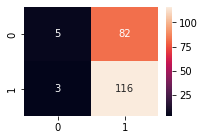

In [39]:
cf_matrix_0 = pd.DataFrame(confusion_matrix(y_test, predictions))
plt.figure(figsize = (3,2))
sn.heatmap(cf_matrix_0, annot=True, fmt='g')

**SVM + TextBlob with SVM with own optimal hyperparameters from grid search**

In [40]:
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
# grid = GridSearchCV(clf, param_grid,refit = True, verbose=2)
grid = GridSearchCV(clf, param_grid,refit = True, verbose=2)
grid.fit(svm_textblob_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, 

[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1000, gamma=1, kernel=linear; total time=  54.1s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [41]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'linear'}

In [42]:
predictions = grid.predict(svm_textblob_test)
print(accuracy_score(y_test, predictions))

0.5776699029126213


<AxesSubplot:>

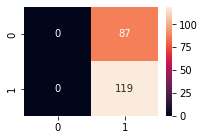

In [43]:
cf_matrix_0 = pd.DataFrame(confusion_matrix(y_test, predictions))
plt.figure(figsize = (3,2))
sn.heatmap(cf_matrix_0, annot=True, fmt='g')

**SVM + TextBlob with hyperparameters from paper**

In [44]:
clf = svm.SVC(kernel='rbf', C=100, gamma=0.001)
clf.fit(svm_textblob_train, y_train)

SVC(C=100, gamma=0.001)

In [45]:
predictions = clf.predict(svm_textblob_test)
print(accuracy_score(y_test, predictions))

0.5776699029126213


<AxesSubplot:>

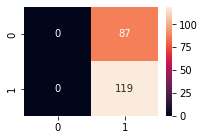

In [46]:
cf_matrix_1 = pd.DataFrame(confusion_matrix(y_test, predictions))
plt.figure(figsize = (3,2))
sn.heatmap(cf_matrix_1, annot=True, fmt='g')

**SVM + TextBlob + TA with SVM with default hyperparameters**

In [47]:
clf = svm.SVC()
clf.fit(svm_textblob_ta_train, y_train)
predictions = clf.predict(svm_textblob_ta_test)
print(accuracy_score(y_test, predictions))

0.5388349514563107


<AxesSubplot:>

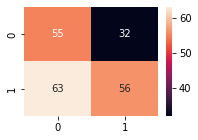

In [48]:
cf_matrix_0 = pd.DataFrame(confusion_matrix(y_test, predictions))
plt.figure(figsize = (3,2))
sn.heatmap(cf_matrix_0, annot=True, fmt='g')

**SVM + TextBlob + TA with SVM with own optimal hyperparameters from grid search**

In [49]:
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
grid = GridSearchCV(clf, param_grid,refit = True, verbose=2)
grid.fit(svm_textblob_ta_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, 

[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [50]:
grid.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'linear'}

In [51]:
predictions = grid.predict(svm_textblob_ta_test)
print(accuracy_score(y_test, predictions))

0.6699029126213593


<AxesSubplot:>

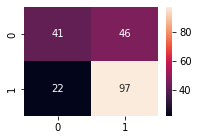

In [52]:
cf_matrix_0 = pd.DataFrame(confusion_matrix(y_test, predictions))
plt.figure(figsize = (3,2))
sn.heatmap(cf_matrix_0, annot=True, fmt='g')

**SVM + TextBlob + TA with hyperparameters from paper**

In [53]:
clf = svm.SVC(kernel='rbf', C=100, gamma=0.001)
clf.fit(svm_textblob_ta_train, y_train)

SVC(C=100, gamma=0.001)

In [54]:
predictions = clf.predict(svm_textblob_ta_test)
print(accuracy_score(y_test, predictions))

0.5922330097087378


<AxesSubplot:>

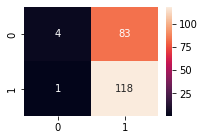

In [55]:
cf_matrix_2 = pd.DataFrame(confusion_matrix(y_test, predictions))
plt.figure(figsize = (3,2))
sn.heatmap(cf_matrix_2, annot=True, fmt='g')